<a href="https://colab.research.google.com/github/JHyunjun/SNU/blob/main/Tensor_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy
import scipy.stats as ss

# Load Data

In [60]:
date_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/snu/w4/실습자료/tensor/tensor/data/date_dic', sep='\t')

In [61]:
feature_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/snu/w4/실습자료/tensor/tensor/data/feature_dic', sep='\t')

In [62]:
stock_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/snu/w4/실습자료/tensor/tensor/data/stock_dic', sep='\t', dtype='str')

In [63]:
date_df.head()

,date
0,2020-01-02
1,2020-01-03
2,2020-01-06
3,2020-01-07
4,2020-01-08


In [64]:
feature_df.head()

,index,feature
0,0,opening_price
1,1,highest_price
2,2,lowest_price
3,3,closing_price
4,4,trading_volume


In [65]:
stock_df.head()

,symbol,name,description,sector
0,000100,Yuhan Corporation,"Yuhan Corporation, a pharmaceutical company, e...",Healthcare
1,000120,CJ Logistics Corporation,CJ Logistics Corporation provides integrated t...,Industrials
2,000270,Kia Corporation,"Kia Corporation, together with its subsidiarie...",Consumer Cyclical
3,000660,SK hynix Inc.,"SK hynix Inc., together with its subsidiaries,...",Technology
4,000720,"Hyundai Engineering & Construction Co., Ltd.","Hyundai Engineering & Construction Co., Ltd. e...",Industrials


In [66]:
stock_data = np.load('/content/drive/MyDrive/Colab Notebooks/snu/w4/실습자료/tensor/tensor/data/stock_data.npy')

In [67]:
stock_data.shape

(100, 123, 5)

# Standardization

In [68]:
for i in tqdm(range(stock_data.shape[0])):
    for k in range(stock_data.shape[2]):
        stock_data[i,:,k] = ss.zscore(stock_data[i,:,k])

100%|██████████| 100/100 [00:00<00:00, 1870.75it/s]


# Draw plot

In [69]:
stock_df[stock_df['symbol']== '005380']

,symbol,name,description,sector
14,005380,Hyundai Motor Company,"Hyundai Motor Company, together with its subsi...",Consumer Cyclical


In [70]:
hyundai_ind = stock_df[stock_df['symbol']== '005380'].index[0]

In [71]:
hyundai_open = stock_data[hyundai_ind, :, 0]
hyundai_tv = stock_data[hyundai_ind, :, 4]

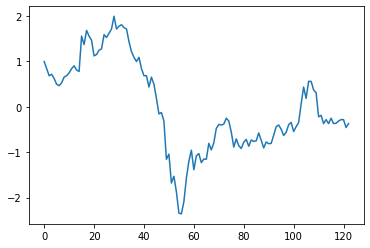

In [72]:
plt.plot(hyundai_open)

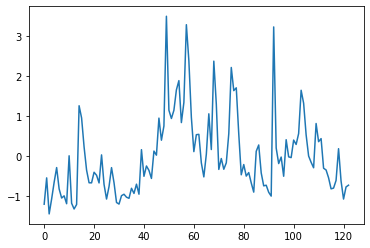

In [73]:
plt.plot(hyundai_tv)

# PARAFAC Decomposition

The following pseudo-code represents PARAFAC2 decomposition for a 3-order tensor.

We will implement PARAFAC decomposition in Python. 

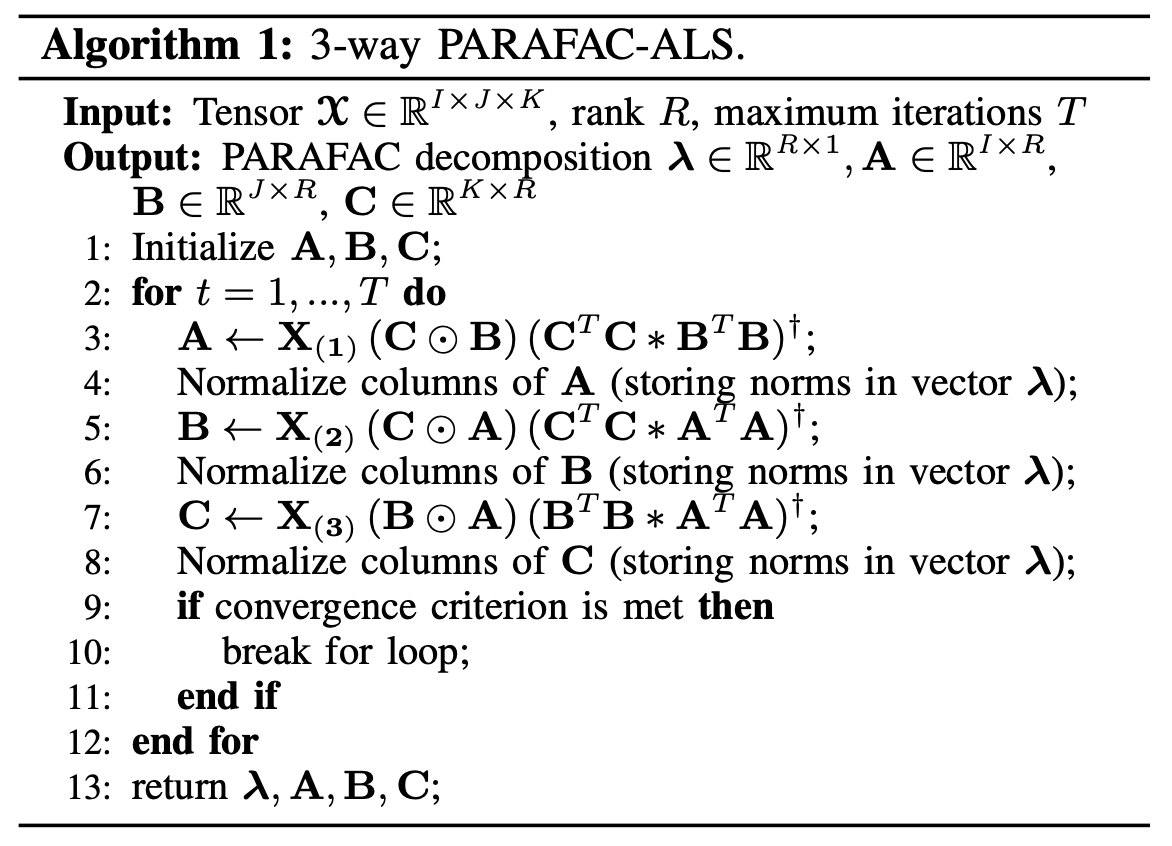

In [74]:
from IPython.display import Image
Image("/content/drive/MyDrive/Colab Notebooks/snu/w4/실습자료/tensor/tensor/img/parafac.png")

## Basic Tensor Operations - Matricization, Khatri–Rao product, Hadamard product

### Matricization

In [75]:
stock_data.shape

(100, 123, 5)

In [76]:
example_tensor = np.zeros((3,4,2))

example_tensor[:,:,0] = np.array([[1,4,7,10],[2,5,8,11],[3,6,9,12]])
example_tensor[:,:,1] = np.array([[13,16,19,22],[14,17,20,23],[15,18,21,24]])

In [77]:
example_mode1_matricization = example_tensor.reshape(example_tensor.shape[0], -1, order='F')


mode1_matricization = stock_data.reshape(stock_data.shape[0], -1, order='F')

In [78]:
print(example_mode1_matricization)

print(mode1_matricization.shape)

[[ 1.  4.  7. 10. 13. 16. 19. 22.]
 [ 2.  5.  8. 11. 14. 17. 20. 23.]
 [ 3.  6.  9. 12. 15. 18. 21. 24.]]
(100, 615)


In [79]:
example_mode2_matricization = np.transpose(example_tensor, (1, 0, 2))
example_mode2_matricization = example_mode2_matricization.reshape(example_tensor.shape[1], -1, order='F')


mode2_matricization = np.transpose(stock_data, (1, 0, 2))
mode2_matricization = mode2_matricization.reshape(stock_data.shape[1], -1, order='F')



In [80]:
print(example_mode2_matricization)

print(mode2_matricization.shape)

[[ 1.  2.  3. 13. 14. 15.]
 [ 4.  5.  6. 16. 17. 18.]
 [ 7.  8.  9. 19. 20. 21.]
 [10. 11. 12. 22. 23. 24.]]
(123, 500)


In [81]:
example_mode3_matricization = np.transpose(stock_data, (2, 0, 1))
example_mode3_matricization = example_tensor.reshape(example_tensor.shape[2], -1, order='F')

mode3_matricization = np.transpose(stock_data, (2, 0, 1))
mode3_matricization = mode3_matricization.reshape(stock_data.shape[2], -1, order='F')

In [82]:
print(example_mode3_matricization)

print(mode3_matricization.shape)


[[ 1.  3.  5.  7.  9. 11. 13. 15. 17. 19. 21. 23.]
 [ 2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24.]]
(5, 12300)


### Khatri-Rao Product

Khatri-Rao Product is the column-wise Kronecker product between two matrices.
$$ \mathbf{C} =  \mathbf{A} \odot \mathbf{B} $$
where $$\mathbf{C} \in \mathbb{R}^{IJ \times R}, \mathbf{A} \in \mathbb{R}^{I \times R}, \mathbf{B} \in \mathbb{R}^{J \times R}$$

In [83]:
factorA = np.random.randn(100, 5)
factorB = np.random.randn(123, 5)

In [84]:
def khatri_rao(A, B):
    return np.vstack([np.kron(A[:, k], B[:, k]) for k in range(B.shape[1])]).T

In [85]:
khatriAB = khatri_rao(factorA, factorB)

In [86]:
khatriAB.shape

(12300, 5)

### Hadamard product

Hadamard product is the element-wise product between two matrices.
$$ \mathbf{C} =  \mathbf{A} * \mathbf{B} $$
where $$\mathbf{C} \in \mathbb{R}^{I \times R}, \mathbf{A} \in \mathbb{R}^{I \times R}, \mathbf{B} \in \mathbb{R}^{I \times R}$$

In [87]:
factorA = np.random.randn(100, 5)
factorB = np.random.randn(100, 5)

In [88]:
hadamardAB = factorA * factorB

In [89]:
hadamardAB.shape

(100, 5)

### Reconstruction

Given factor matrices and lambda values, we can reconstruct an input tensor using them.
$$ \mathbf{\mathcal{X}} \approx [\![\lambda ; \mathbf{A}, \mathbf{B}, \mathbf{C} ]\!] $$

<!-- In terms of mode-1:
$$ \mathbf{X}_{(1)} \approx \mathbf{A}diag(\lambda)(\mathbf{C}\odot\mathbf{B})$$

In terms of mode-2:
$$ \mathbf{X}_{(2)} \approx \mathbf{B}diag(\lambda)(\mathbf{C}\odot\mathbf{A})$$

In terms of mode-3:
$$ \mathbf{X}_{(3)} \approx \mathbf{C}diag(\lambda)(\mathbf{B}\odot\mathbf{A})$$
 -->

In [90]:
factorA = np.random.randn(100, 3)
factorB = np.random.randn(123, 3)
factorC = np.random.randn(3, 3)
lambdas = np.random.randn(3)

In [91]:
reconstruction = np.zeros((3,3,3))

for i in range(3):
    reconstruction[i,i,i] = lambdas[i]
    
reconstruction = np.einsum('aj, bk, cl, jkl->abc', factorA, factorB, factorC, reconstruction)

In [92]:
reconstruction.shape

(100, 123, 3)

# Updating Factor Matrix

In [93]:
def updatingFactor(data, factorA, factorB, factorC, mode):
    
    updatedFactor = None
    lambda_val = None
    if mode == 1:
        matricization = stock_data.reshape(data.shape[0], -1, order='F')
        khatriCB = khatri_rao(factorC, factorB)
        inv_hadamardCB = np.linalg.inv(np.matmul(factorC.T, factorC) * np.matmul(factorB.T, factorB))
        updatedFactor = np.matmul(matricization, khatriCB) 
        updatedFactor = np.matmul(updatedFactor, inv_hadamardCB)
        lambda_val = np.zeros((updatedFactor.shape[1],))
        for k in range(updatedFactor.shape[1]):
            lambda_val[k] = np.linalg.norm(updatedFactor[:,k])
            updatedFactor[:,k] = updatedFactor[:,k]/lambda_val[k]
        
    elif mode == 2:
        matricization = np.transpose(data, (1, 0, 2))
        matricization = matricization.reshape(data.shape[1], -1, order='F')
        khatriCA = khatri_rao(factorC, factorA)
        inv_hadamardCA = np.linalg.inv(np.matmul(factorC.T, factorC) * np.matmul(factorA.T, factorA))
        updatedFactor = np.matmul(matricization, khatriCA) 
        updatedFactor = np.matmul(updatedFactor, inv_hadamardCA)
        lambda_val = np.zeros((updatedFactor.shape[1],))
        for k in range(updatedFactor.shape[1]):
            lambda_val[k] = np.linalg.norm(updatedFactor[:,k])
            updatedFactor[:,k] = updatedFactor[:,k]/lambda_val[k]
            
    else:
        matricization = np.transpose(data, (2, 0, 1))
        matricization = matricization.reshape(data.shape[2], -1, order='F')          
        khatriBA = khatri_rao(factorB, factorA)
        inv_hadamardBA = np.linalg.inv(np.matmul(factorB.T, factorB) * np.matmul(factorA.T, factorA))
        updatedFactor = np.matmul(matricization, khatriBA) 
        updatedFactor = np.matmul(updatedFactor, inv_hadamardBA)        
        lambda_val = np.zeros((updatedFactor.shape[1],))
        for k in range(updatedFactor.shape[1]):
            lambda_val[k] = np.linalg.norm(updatedFactor[:,k])
            updatedFactor[:,k] = updatedFactor[:,k]/lambda_val[k]    
    
    return updatedFactor, lambda_val

# Iteratively update factor matrices

In [94]:
np.random.seed(seed=4) 


maxiters = 20
rank = 3
factorA = np.random.randn(stock_data.shape[0], rank)
factorB = np.random.randn(stock_data.shape[1], rank)
factorC = np.random.randn(stock_data.shape[2], rank)
lambdas = np.zeros((rank,))
errors = []

In [95]:
for iters in tqdm(range(maxiters)):
    updatedFactorMatrixA, updated_labmda_val = updatingFactor(stock_data, factorA, factorB, factorC, 1)
    factorA = updatedFactorMatrixA
    lambdas =  updated_labmda_val
    
    updatedFactorMatrixB, updated_labmda_val = updatingFactor(stock_data, factorA, factorB, factorC, 2)
    factorB = updatedFactorMatrixB
    lambdas =  updated_labmda_val

    updatedFactorMatrixC, updated_labmda_val = updatingFactor(stock_data, factorA, factorB, factorC, 3)
    factorC = updatedFactorMatrixC
    lambdas =  updated_labmda_val
    
    reconstruction = np.zeros((rank, rank, rank))
    for i in range(rank):
        reconstruction[i,i,i] = lambdas[i]
    
    reconstruction = np.einsum('aj, bk, cl, jkl->abc', factorA, factorB, factorC, reconstruction)
    
    error = np.sum(np.square(stock_data - reconstruction))/np.sum(np.square(stock_data))
    
    errors  = errors + [error]
    

100%|██████████| 20/20 [00:00<00:00, 29.38it/s]


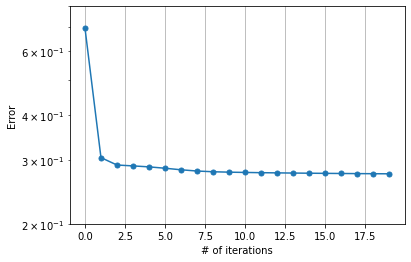

In [96]:
plt.semilogy(errors, marker='o', markersize=5)
plt.ylim(ymin=0.2, ymax=0.8)
plt.ylabel('Error')
plt.xlabel('# of iterations')
plt.grid(True)
plt.show()

# Trend Analysis

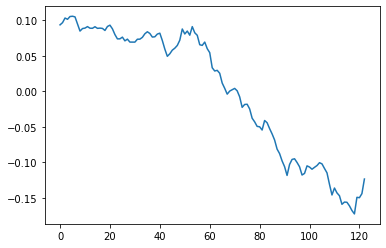

In [97]:
plt.plot(factorB[:,0])

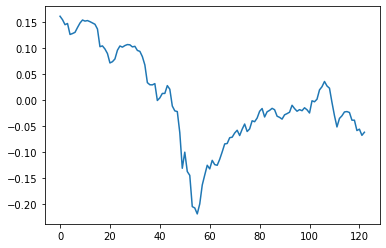

In [98]:
plt.plot(factorB[:,1])

In [99]:
lambdas

array([ 96.40864207, 183.14910055,  67.24183161])

# Clustering

In [100]:
from sklearn.cluster import KMeans

In [101]:
kmeans = KMeans(n_clusters=25, random_state=0).fit(factorA)

In [102]:
hyundai_cluster_ind = np.where(kmeans.labels_ == kmeans.labels_[14])[0]

In [103]:
stock_df.loc[hyundai_cluster_ind]

,symbol,name,description,sector
2,000270,Kia Corporation,"Kia Corporation, together with its subsidiarie...",Consumer Cyclical
9,003490,"Korean Air Lines Co., Ltd.","Korean Air Lines Co., Ltd. provides airline se...",Industrials
14,005380,Hyundai Motor Company,"Hyundai Motor Company, together with its subsi...",Consumer Cyclical
39,012330,"Hyundai Mobis Co.,Ltd","Hyundai Mobis Co.,Ltd manufactures and sells a...",Consumer Cyclical
49,021240,"COWAY Co., Ltd.","Coway Co., Ltd. operates in the home wellness ...",Consumer Cyclical
54,028670,"Pan Ocean Co., Ltd.","Pan Ocean Co., Ltd., together with its subsidi...",Industrials
60,034020,"Doosan Heavy Industries & Construction Co., Ltd.","Doosan Heavy Industries & Construction Co., Lt...",Industrials
78,086790,Hana Financial Group Inc.,"Hana Financial Group Inc., through its subsidi...",Financial Services
86,161390,"Hankook Tire & Technology Co., Ltd.","Hankook Tire & Technology Co., Ltd. manufactur...",Consumer Cyclical
89,241560,Doosan Bobcat Inc.,"Doosan Bobcat Inc. designs, manufactures, mark...",Industrials
